# TODO LIST

<ul>
    <li>Analyze amount of occurrences for each emotion</li>
    <li>top images for each emotion</li>
    <li>difference between silver and gold label</li>
    <li>wordcloud w/ most common words for each emotion</li>
    <li>correlation btw/ pairs of labels</li>
    <li></li>
</ul>

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
with open('dataset/gold_label_dataset.pkl', 'rb') as file:
    df = pd.compat.pickle_compat.load(file) 

In [21]:
emotions = df.columns[df.columns.str.startswith("M_")].values.tolist()
emotions = [e[2:].lower() for e in emotions]
emotions

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'neutral',
 'sadness',
 'something else',
 'surprise',
 'trust']

## Analyze amount of labels for each

In [22]:
cols = df.columns[df.columns.str.startswith("label_")].tolist()
freq_counts = {e: dict.fromkeys(emotions, 0) for e in cols}

for index, row in df.iterrows():
    for column in cols:
        for elem in row[column]:
            freq_counts[column][elem] += 1

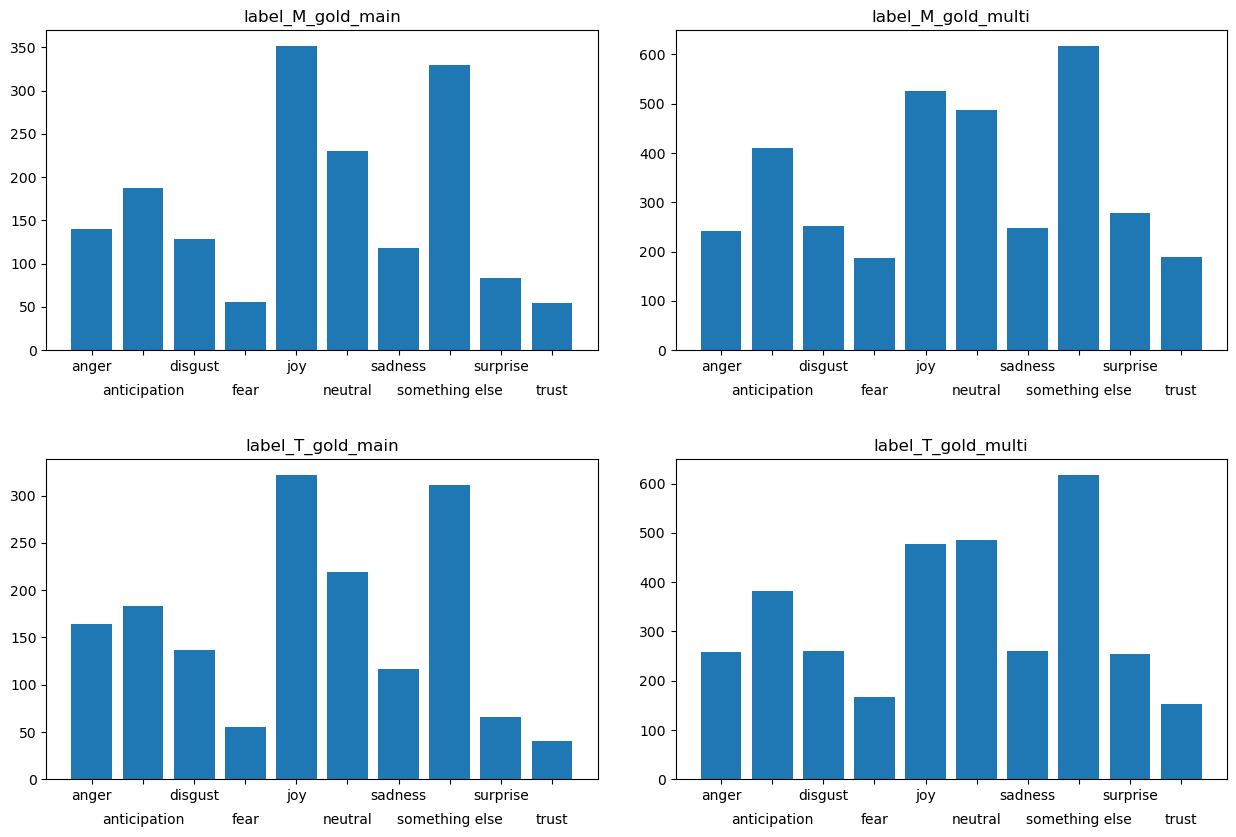

In [23]:
fig, axs = plt.subplots(2, 2, figsize = (13, 9))
for i, ax in enumerate(axs.reshape(-1)):
    ax.bar(freq_counts[cols[i]].keys(), freq_counts[cols[i]].values())
    ax.set_title(cols[i])
    labels = ax.get_xticklabels()
    for i, label in enumerate(labels):
        label.set_y(label.get_position()[1] - (i % 2) * 0.075)
fig.tight_layout(pad=3)
plt.show()

## Difference between silver and gold label

In [24]:
for column in cols:
    count = 0
    for i, row in df.iterrows():
        if row["uni_label"] not in row[column]:
            count += 1
    print(column, ":", count)

label_M_gold_main : 618
label_M_gold_multi : 436
label_T_gold_main : 597
label_T_gold_multi : 425


In [25]:
for column in cols:
    count = 0
    for i, row in df.iterrows():
        if set(row["multi_label"]).isdisjoint(row[column]):
            count += 1
    print(column, ":", count)

label_M_gold_main : 544
label_M_gold_multi : 348
label_T_gold_main : 502
label_T_gold_multi : 330


## Difference between text only and multimodal labels

In [26]:
count = 0
for i, row in df.iterrows():
    if set(row["label_M_gold_main"]).isdisjoint(row["label_T_gold_main"]):
        count += 1
print(count)

214


In [27]:
count = 0
for i, row in df.iterrows():
    if set(row["label_M_gold_multi"]).isdisjoint(row["label_T_gold_multi"]):
        count += 1
print(count)

28


## Correlation between label scores

<Axes: >

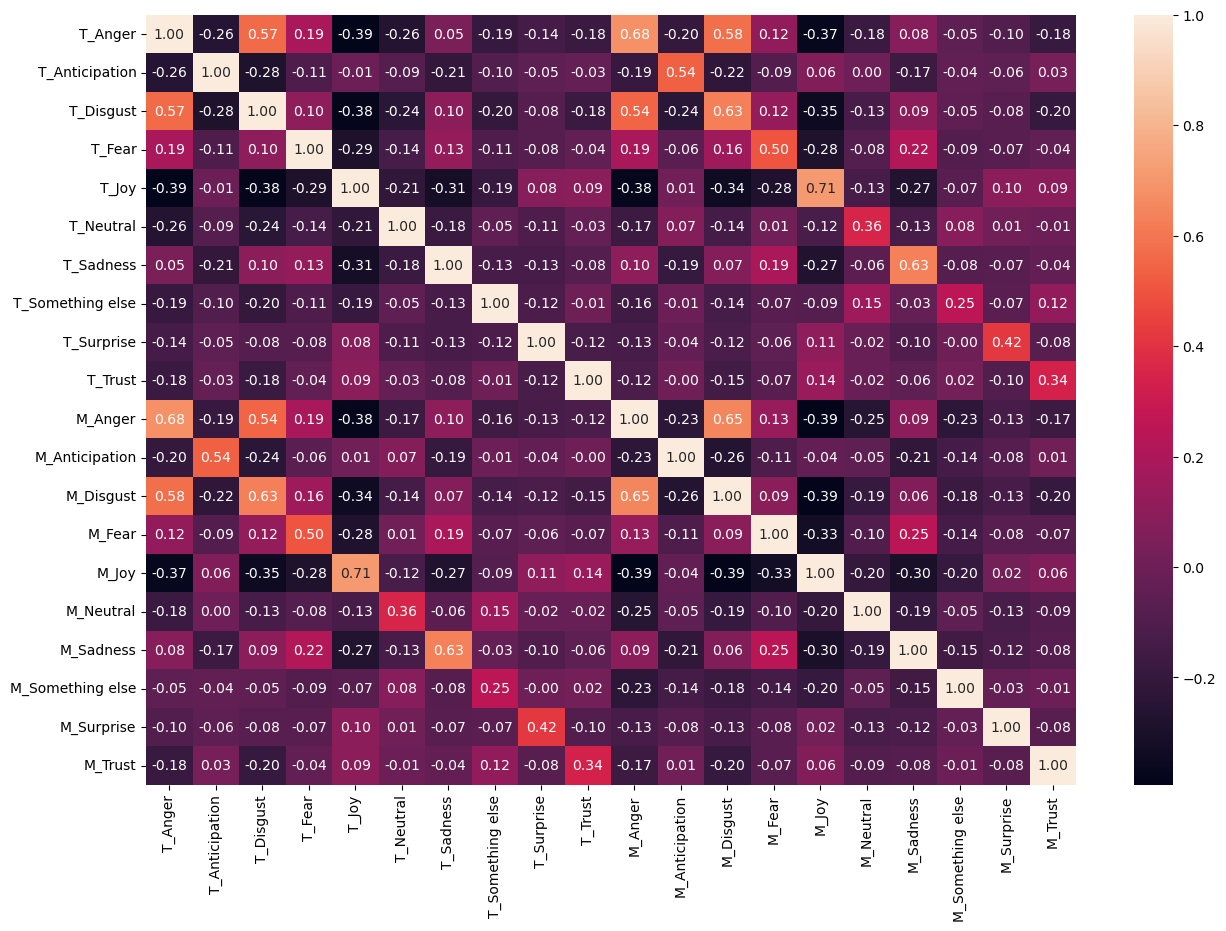

In [28]:
import seaborn as sns

cols = df.columns[df.columns.str.startswith("T_")].tolist() + df.columns[df.columns.str.startswith("M_")].tolist()
fig = plt.figure(figsize=(15, 10))
sns.heatmap(df[cols].corr(), annot = True, fmt = '.2f')